In [114]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import RandomRotation
import torch
from torchvision.transforms import (
    Compose,
    Normalize,
    CenterCrop
)
import torchvision
import os
import math
import warnings
warnings.filterwarnings('ignore')

import math
import torch
import os
from torchvision.transforms import (
    Compose,
    Resize,
    RandomCrop
)
from torchvision.transforms import (
    RandomHorizontalFlip,
    RandomRotation,
    RandomVerticalFlip,
    RandomApply,
    InterpolationMode,
    RandomCrop,
    RandomResizedCrop
)
from matplotlib import pyplot as plt
from einops import rearrange
import warnings
warnings.filterwarnings('ignore')
import numpy as np

In [176]:
def augment_image_with_map(_img, _map):
    side_outer = 512
    angle = torch.randint(low=0, high=90, size=(1,)).item()
    
    aug1 = torch.nn.Sequential(RandomRotation((angle, angle)))
    
    side_inner = side_outer / (math.cos(math.radians(angle)) + math.sin(math.radians(angle)))
    print(f"The new h and w are: {side_inner}")
    
    state = torch.get_rng_state()
    _img = aug1(_img)

    torch.set_rng_state(state)
    _map = aug1(_map)
    
    center_x = side_outer // 2
    center_y = side_outer // 2

    half_width = side_inner // 2
    half_height = side_inner // 2 

    start_x = round(center_x - half_width)
    end_x = round(center_x + half_width)
    start_y = round(center_y - half_height)
    end_y = round(center_y + half_height)

    _img = _img[:, start_y:end_y, start_x:end_x]
    _map = _map[:, start_y:end_y, start_x:end_x]
    
    aug2 = torch.nn.Sequential(
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5),
    RandomResizedCrop(size=(224, 224), scale=(0.5, 2.0)))
    
    state = torch.get_rng_state()
    _img = aug2(_img)

    torch.set_rng_state(state)
    _map = aug2(_map)
    
    
    return _img, _map

In [169]:
class HirschImagesDataset(Dataset):
    def __init__(self, data_file_path, do_augmentation):
        self.data_file_path = data_file_path 
        self.all_paths = os.listdir((data_file_path))
        self.do_augmentation = do_augmentation
        
        if do_augmentation:
            self.augment = augment_image_with_map
        else:
            self.augment = self.identity_function
                
    def identity_function(self, img, muscle_map):
        return img, muscle_map
                
    def __len__(self):
        return len(self.all_paths)
        
    def  __getitem__(self, index):
        #loaded_tensor = torch.load(self.all_paths[index])
        loaded_tensor = torch.load(os.path.join(self.data_file_path, self.all_paths[index]))
        img = loaded_tensor['imgs']
        muscle_map = loaded_tensor['muscles_map']
        img, muscle_map = self.augment(img, muscle_map)
        return img, muscle_map

In [177]:
train_dataset = HirschImagesDataset(data_file_path="test", do_augmentation=True)
val_dataset = HirschImagesDataset(data_file_path="test1", do_augmentation=False)
test_dataset = HirschImagesDataset(data_file_path="test2", do_augmentation=False)

In [178]:
train_loader = DataLoader(train_dataset,
                          batch_size=96,
                          shuffle=True,
                          num_workers=8
)

val_loader = DataLoader(val_dataset,
                          batch_size=96,
                          shuffle=False,
                          num_workers=8
)

test_loader = DataLoader(test_dataset,
                          batch_size=96,
                          shuffle=False,
                          num_workers=8
)

In [179]:
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")
print(f"Test Dataset Length: {len(test_dataset)}")

Train Dataset Length: 2
Validation Dataset Length: 2
Test Dataset Length: 2


In [180]:
img, muscle_map = train_dataset[1]

img.shape, muscle_map.shape

The new h and w are: 402.8049289581146


(torch.Size([3, 224, 224]), torch.Size([1, 224, 224]))

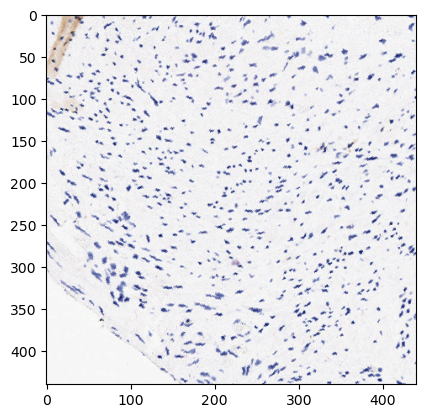

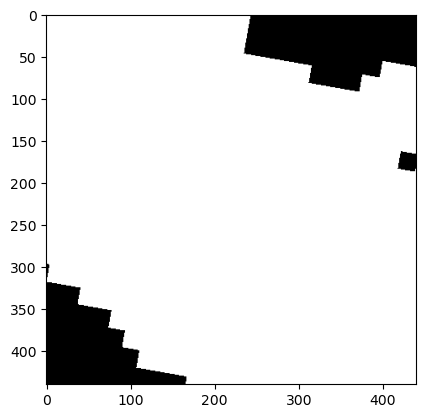

In [174]:
plt.imshow(rearrange(img, 'c h w -> h w c'))
plt.show()

plt.imshow(rearrange(muscle_map, 'c h w -> h w c'), cmap='gray')
plt.show()